In [34]:
import logging
import pickle
import numpy as np 
import matplotlib.pyplot as plt 
import sys

from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import cross_validation 
from sklearn.naive_bayes import GaussianNB 
from sklearn.datasets import load_digits 
from sklearn.learning_curve import learning_curve 
from sklearn.cross_validation import ShuffleSplit, train_test_split 
from sklearn.grid_search import GridSearchCV




In [35]:
from sellibrary.gbrt import GBRTWrapper
from sellibrary.text_file_loader import load_feature_matrix
from sellibrary.filter_only_golden import FilterGolden
from sellibrary.locations import FileLocations
from sellibrary.wiki.wikipedia_datasets import WikipediaDataset
from sellibrary.sel.dexter_dataset import DatasetDexter

from sellibrary.util.test_train_splitter import DataSplitter

INTERMEDIATE_PATH = FileLocations.get_dropbox_intermediate_path()

In [3]:
# setup logging


handler = logging.StreamHandler()
handler.setFormatter(logging.Formatter('%(asctime)s %(name)-12s %(levelname)-8s %(message)s'))
logger = logging.getLogger(__name__)
logger.addHandler(handler)
logger.propagate = False
logger.setLevel(logging.INFO)



In [4]:


def get_r2_train_model(filename, number_features_per_line, feature_names):


    X, y, docid_array, entity_id_array = load_feature_matrix(feature_filename=INTERMEDIATE_PATH + filename,
                                                             feature_names=feature_names,
                                                             entity_id_index=1,
                                                             y_feature_index=2, 
                                                             first_feature_index=4, 
                                                             number_features_per_line=number_features_per_line,
                                                             tmp_filename='/tmp/temp_conversion_file.txt'
                                                             )
    
    # train only on records we have a golden salience for
    fg = FilterGolden()
    logger.info('X Shape = %s',X.shape)
    logger.info('y Shape = %s',y.shape)
    
    dexter_dataset = DatasetDexter()
    wikipedia_dataset = WikipediaDataset()

    X2, y2, docid2, entityid2 = fg.get_only_golden_rows(X, y, docid_array, entity_id_array, dexter_dataset, wikipedia_dataset )

#     X2, y2, docid2, entityid2 = fg.get_only_golden_rows(X, y, docid_array, entity_id_array)

    
    
    wrapper = GBRTWrapper()
    gbrt = wrapper.train_model_no_split(X2, y2,  n_estimators=40)
    logger.info('trained')
    #gbrt.save_model()

    # from https://shankarmsy.github.io/stories/gbrt-sklearn.html
    #One of the benefits of growing trees is that we can understand how important each of the features are 
    print ("Feature Importances" )
    print (gbrt.feature_importances_) 
    print ()
    #Let's print the R-squared value for train/test. This explains how much of the variance in the data our model is 
    #able to decipher. 
    print ("R-squared for Train: %.2f" %gbrt.score(X2, y2) )
    #print ("R-squared for Test: %.2f" %gbrt.score(X_test, y_test) )
    #- See more at: https://shankarmsy.github.io/stories/gbrt-sklearn.html#sthash.JNZQbnph.dpuf
    return gbrt, X2, y2, docid2, entityid2
    




In [5]:

#All right let's do this the right way. We'll use a cross-validation generator to 
# select train and CV datasets to finetune parameters such as C 
# (Regularization parameter we saw earlier). These hyperparameters are extremely critical to 
# the model. 
#Now, if we tune parameters against the Test dataset, we will end up biasing towards the test 
# set and will once again not generalize very well. We will also have no good way to find out 
# since we have essentially trained on all our data. 
#Luckily scikit-learn has builit-in packages that can help with this. We'll use a crossvalidation 
# generator that can train the model by tuning the parameters based on a cross-validation subset 
# (cv) that is picked from within the training set. A different cv subset will be picked for each iteration, we control the number of iterations. Then we will 
#use these cv/train splits and run a gridsearch function that will evaluate the model with each split and tune parameters 
#to give us the best parameter that gives the optimal result.

#Defining this as a function so we can call it anytime we want



def GradientBooster(param_grid, n_jobs, X, y, estimator):
    
    #Choose cross-validation generator - let's choose ShuffleSplit which randomly shuffles and selects Train and CV sets 
    #for each iteration. There are other methods like the KFold split.
    cv = ShuffleSplit(X.shape[0], n_iter=10, test_size=0.2)
    #Apply the cross-validation iterator on the Training set using GridSearchCV. This will run the classifier on the 
    #different train/cv splits using parameters specified and return the model that has the best results 

    # 
    #Note that we are tuning based on the F1 score 2PR/P+R where P is Precision and R is Recall. This may not always be 
    #the best score to tune our model on.  For now, we'll use F1.
    classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=param_grid, n_jobs=n_jobs)
    #Also note that we're feeding multiple neighbors to the GridSearch to try out. 
    #We'll now fit the training dataset to this classifier
    classifier.fit(X, y)
    #Let's look at the best estimator that was found by GridSearchCV
    print ("Best Estimator learned through GridSearch")
    print ( classifier.best_estimator_)
    return cv, classifier.best_estimator_, classifier
    


In [6]:
def get_num_jobs():
    if sys.platform == 'win32':
        return 8
    else:
        if sys.platform == 'linux': # Sherlock ML
            return 8
        else:
            return 4 # mac

In [7]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)): 
    
    """ Generate a simple plot of the test and traning learning curve. 
    Parameters ---------- 
    estimator : object type that implements the "fit" and "predict" methods An object of that type which is cloned for each validation. 
    title : string Title for the chart. 
    X : array-like, shape (n_samples, n_features) Training vector, where n_samples is the number of samples and n_features is the number of features. 
    y : array-like, shape (n_samples) or (n_samples, n_features), optional Target relative to X for classification or regression; None for unsupervised learning. 
    ylim : tuple, shape (ymin, ymax), optional Defines minimum and maximum yvalues plotted. 
    cv : integer, cross-validation generator, optional If an integer is passed, it is the number of folds (defaults to 3). Specific cross-validation objects can be passed, see sklearn.cross_validation module for the list of possible objects 
    n_jobs : integer, optional Number of jobs to run in parallel (default 1). """ 
    plt.figure()
    plt.title(title)
    if ylim is not None: plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt
                  

In [8]:
def print_info(best_est, X, y, tset):
    print ("--------------------------------" )
    print (tset+" Best Estimator Parameters" )
    print ("--------------------------------" )
    print ("n_estimators: %d" %best_est.n_estimators )
    print ("max_depth: %d" %best_est.max_depth )
    print ("min_samples_leaf: %d" %best_est.min_samples_leaf )
    print ("max_features: %.2f" %best_est.max_features )
    print (tset+" R-squared: %.2f" %best_est.score(X,y) )     
    print ("Learning Rate: %.2f" %best_est.learning_rate )

 

In [9]:

def perform_grid_search(X,y):

    # if no space left on device, try setting the env ver JOBLIB_TEMP_FOLDER to /tmp
    %env JOBLIB_TEMP_FOLDER=/tmp
    #WARNING - THIS MIGHT TAKE A WHILE TO RUN. 
    # TRY ADJUSTING parameters such as n_jobs (jobs to run in parallel, before 
    #increasing this make sure your system can handle it), n_iter for ShuffleSplit 
    # (in the function definition) and reducing #number of values being tried for max_depth/n_estimators. 
    #SELECT INTERRUPT IN THE MENU AND PRESS INTERRUPT KERNEL IF YOU NEEDD TO STOP EXECUTION 
    logger.info('starting')

    param_grid={'n_estimators':[450, 500, 550], # tried 250, 100, [50], 25
                'learning_rate': [0.02, 0.01, 0.005],# tried 0.2, 0.1, [0.05], 0.02, 0.01],
                'max_depth':[7, 9, 12], # tried 6,[9],12
                'min_samples_leaf':[18, 20, 22], # tried  2,5,9,12,15,[18]
                'max_features':[0.2,0.3,0.4] # tried 0.2,[0.3],0.4,0.5
               } 
    n_jobs = get_num_jobs() 

    #Let's fit GBRT to the digits training dataset by calling the function we just created. 
    estimator = GradientBoostingRegressor()

    cv, best_est, trained_model=GradientBooster(param_grid, n_jobs, X, y, estimator) 
    logger.info('complete')
    print_info(best_est, X, y, '.8CV')
    
    return cv, best_est


            

# Load Data

In [10]:
sent_feature_names = [
    'title_sentiment_ngram_20', 
    'title_neg_sent_ngram_20',
    'title_pos_sent_ngram_20',   
    'body_sentiment_ngram_20', 
    'body_neg_sent_ngram_20',
    'body_pos_sent_ngram_20'
]    


X_sent, y_sent, docid_array_sent, entity_id_array_sent = load_feature_matrix(
    feature_filename=INTERMEDIATE_PATH+'sentiment_simple.txt',
    feature_names=sent_feature_names,
    entity_id_index=1,
    y_feature_index=2, first_feature_index=4, number_features_per_line=10,
    tmp_filename='/tmp/temp_conversion_file.txt'
    )







2018-07-16 11:36:12,197 sellibrary.text_file_loader INFO     loading data from : /Users/dsluis/Dropbox/Datasets/intermediate/sentiment_simple.txt
2018-07-16 11:36:12,230 sellibrary.text_file_loader INFO     4715 lines loaded from /Users/dsluis/Dropbox/Datasets/intermediate/sentiment_simple.txt


# Perform Grid Search

In [11]:
cv, best_est = perform_grid_search(X_sent,y_sent)

2018-07-16 11:36:13,739 __main__     INFO     starting


env: JOBLIB_TEMP_FOLDER=/tmp


2018-07-16 11:43:48,041 __main__     INFO     complete


Best Estimator learned through GridSearch
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=7, max_features=0.2,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=20,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=550, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)
--------------------------------
.8CV Best Estimator Parameters
--------------------------------
n_estimators: 550
max_depth: 7
min_samples_leaf: 20
max_features: 0.20
.8CV R-squared: 0.26
Learning Rate: 0.01


2018-07-16 11:43:48,130 __main__     INFO     starting


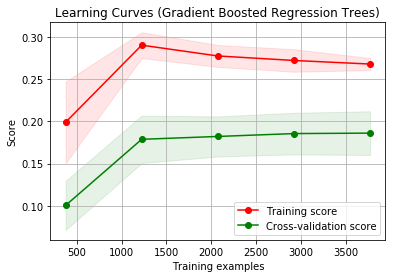

2018-07-16 11:43:53,915 __main__     INFO     complete


In [12]:
#OK we'll now call the plot_learning_curve module by feeding it the estimator (best estimator returned from GS) 
#and train/cv sets. 
#The module simply runs the estimator multiple times on subsets of the data provided and plots the train and cv scores. 
#Note that we're feeding the best parameters we've learned from GridSearchCV to the estimator now. 
#We may need to adjust the hyperparameters further if there is overfitting (or underfitting, though unlikely) 

logger.info('starting')
title = "Learning Curves (Gradient Boosted Regression Trees)" 
n_jobs = get_num_jobs()
gbr_estimator = GradientBoostingRegressor(n_estimators=best_est.n_estimators, 
                                      max_depth=best_est.max_depth, 
                                      learning_rate=best_est.learning_rate, 
                                      min_samples_leaf=best_est.min_samples_leaf, 
                                      max_features=best_est.max_features) 
plot_learning_curve(gbr_estimator, title, X_sent, y_sent, cv=cv, n_jobs=n_jobs) 

plt.show() 
logger.info('complete')

# R-squared revers to the proportion of variation in data that can be explained by our model. 
# 1.0 is perfect, 0.05 not very useful
# Distance between train and cross validation = 
# Gradient suggest whether more training data is useful
# How does the number of estimators affect the curve?




# Make Prediction

In [57]:
splitter = DataSplitter()



X_train, X_test, y_train, y_test, in_train_set_by_id = splitter.get_test_train_datasets(X_sent,y_sent,docid_array_sent,7,train_split=0.50)



In [58]:
print(X_train.shape)
print(X_test.shape)

(2414, 6)
(2301, 6)


In [59]:
in_train_set_by_id

ids_in_trainset = []
for i in in_train_set_by_id.keys():
    if in_train_set_by_id[i]:
        ids_in_trainset.append(int(i))
        
len(ids_in_trainset)
s = str(ids_in_trainset)
s = s.replace(' ','').replace('[','').replace(']','')

print(s)
    

1,2,4,6,7,9,10,11,12,13,16,17,22,24,26,27,28,29,31,34,36,37,38,40,41,43,44,49,54,56,57,60,62,63,71,75,78,81,86,87,89,90,91,93,94,96,98,99,101,103,108,109,110,113,114,115,116,118,123,124,125,126,136,141,144,145,148,149,150,151,153,154,155,156,157,158,159,162,163,165,166,167,170,171,172,173,174,175,178,179,182,184,189,190,191,195,196,204,206,207,208,209,210,213,217,218,219,221,222,226,229,235,236,238,241,242,245,246,247,250,254,256,257,262,265,266,267,268,270,271,272,274,275,278,283,284,285,288,290,291,294,299,301,302,308,315,317,323,327,329,330,331,332,333,338,341,530,532,534,540,541,543,544,545,548,551,552,553,561,568,569,570,572,573,574,577,578,582,583,587,588,592,594,596,597,600,601,603,604


In [60]:

gbr_estimator.fit(X_train,y_train)
print ("Feature Importances" )
print (gbr_estimator.feature_importances_) 
print ()
#Let's print the R-squared value for train/test. This explains how much of the variance in the data our model is 
#able to decipher. 
print ("R-squared for Train: %.2f" %gbr_estimator.score(X_test, y_test) )




a = np.ones([1,6])
gbr_estimator.predict(a)[0]

Feature Importances
[ 0.18089231  0.0981509   0.14288074  0.20940423  0.17789432  0.1907775 ]

R-squared for Train: 0.22


2.550454593323344

# Save Model

In [61]:
output_filename = INTERMEDIATE_PATH+'simple_sentiment_GradientBoostingRegressor.pickle'
with open(output_filename, 'wb') as handle:
     pickle.dump(gbr_estimator, handle, protocol=pickle.HIGHEST_PROTOCOL)



0.01